<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

# Artificial Intelligence in Finance

## Data-Driven Finance (b)

Dr Yves J Hilpisch | The AI Machine

http://aimachine.io | http://twitter.com/dyjh

## Debunking Central Assumptions

## Normality

#### Sample Data Sets

In [1]:
import numpy as np
import pandas as pd
from pylab import plt, mpl
np.random.seed(100)
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [2]:
N = 10000

In [3]:
snrn = np.random.standard_normal(N)
snrn -= snrn.mean()  # moment matching
snrn /= snrn.std()  # moment matching

In [4]:
round(snrn.mean(), 4)

-0.0

In [5]:
round(snrn.std(), 4)

1.0

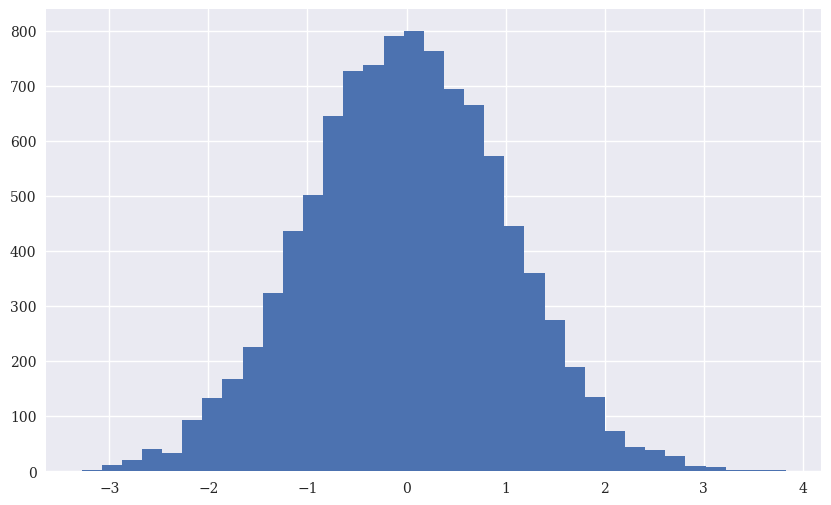

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(snrn, bins=35);

In [7]:
numbers = np.ones(N) * 1.5
split = int(0.25 * N)
numbers[split:3 * split] = -1
numbers[3 * split:4 * split] = 0

In [8]:
numbers -= numbers.mean()
numbers /= numbers.std()

In [9]:
round(numbers.mean(), 4)

0.0

In [10]:
round(numbers.std(), 4)

1.0

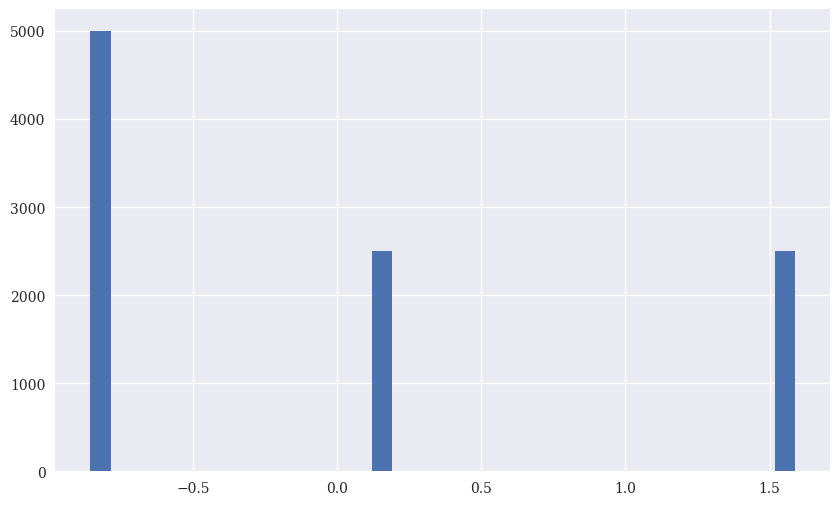

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(numbers, bins=35);

In [12]:
import math
import scipy.stats as scs
import statsmodels.api as sm

In [13]:
def dN(x, mu, sigma):
    ''' Probability density function of a normal random variable x.
    '''
    z = (x - mu) / sigma
    pdf = np.exp(-0.5 * z ** 2) / math.sqrt(2 * math.pi * sigma ** 2)
    return pdf

In [14]:
def return_histogram(rets, title=''):
    ''' Plots a histogram of the returns.
    '''
    plt.figure(figsize=(10, 6))
    x = np.linspace(min(rets), max(rets), 100)
    plt.hist(np.array(rets), bins=50,
             density=True, label='frequency')
    y = dN(x, np.mean(rets), np.std(rets))
    plt.plot(x, y, linewidth=2, label='PDF')
    plt.xlabel('log returns')
    plt.ylabel('frequency/probability')
    plt.title(title)
    plt.legend()

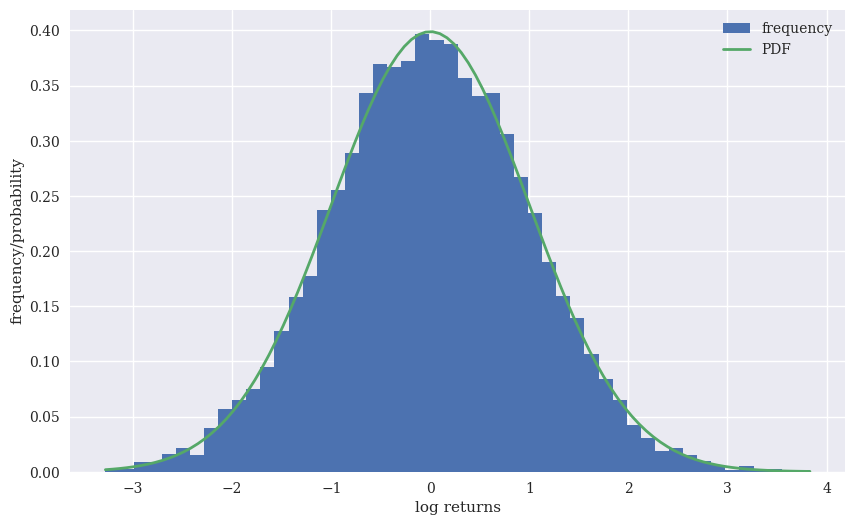

In [15]:
return_histogram(snrn)

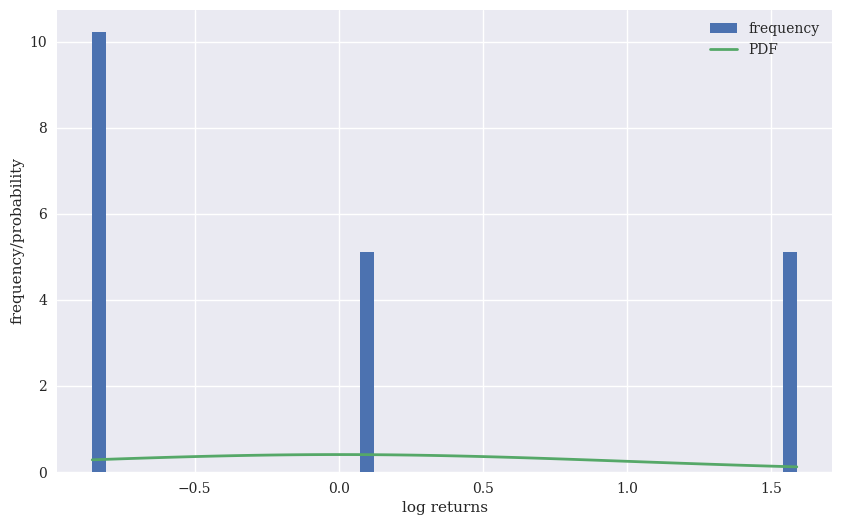

In [16]:
return_histogram(numbers)

In [17]:
def return_qqplot(rets, title=''):
    ''' Generates a Q-Q plot of the returns.
    '''
    fig = sm.qqplot(rets, line='s', alpha=0.5)
    fig.set_size_inches(10, 6)
    plt.title(title)
    plt.xlabel('theoretical quantiles')
    plt.ylabel('sample quantiles')

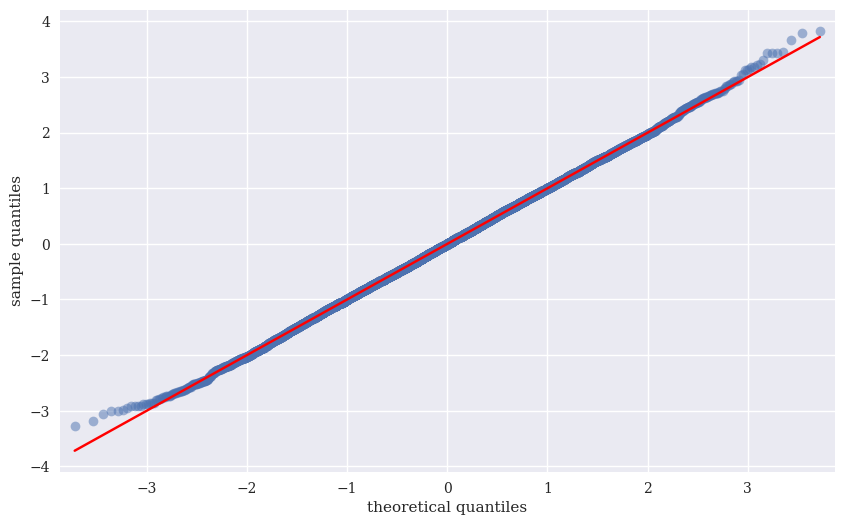

In [18]:
return_qqplot(snrn)

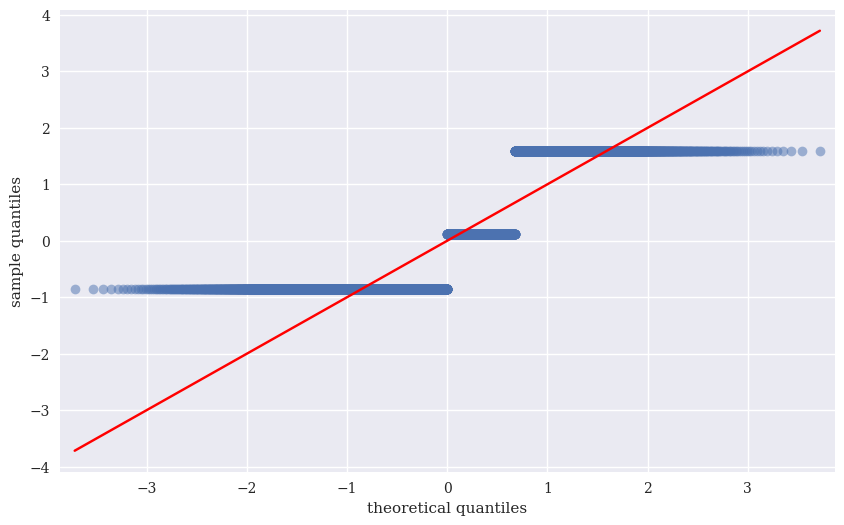

In [19]:
return_qqplot(numbers)

In [20]:
def print_statistics(rets):
    print('RETURN SAMPLE STATISTICS')
    print('---------------------------------------------')
    print('Skew of Sample Log Returns {:9.6f}'.format(
                scs.skew(rets)))
    print('Skew Normal Test p-value   {:9.6f}'.format(
                scs.skewtest(rets)[1]))
    print('---------------------------------------------')
    print('Kurt of Sample Log Returns {:9.6f}'.format(
                scs.kurtosis(rets)))
    print('Kurt Normal Test p-value   {:9.6f}'.format(
                scs.kurtosistest(rets)[1]))
    print('---------------------------------------------')
    print('Normal Test p-value        {:9.6f}'.format(
                scs.normaltest(rets)[1]))
    print('---------------------------------------------')

In [21]:
print_statistics(snrn)

RETURN SAMPLE STATISTICS
---------------------------------------------
Skew of Sample Log Returns  0.016793
Skew Normal Test p-value    0.492685
---------------------------------------------
Kurt of Sample Log Returns -0.024540
Kurt Normal Test p-value    0.637637
---------------------------------------------
Normal Test p-value         0.707334
---------------------------------------------


In [22]:
print_statistics(numbers)

RETURN SAMPLE STATISTICS
---------------------------------------------
Skew of Sample Log Returns  0.689254
Skew Normal Test p-value    0.000000
---------------------------------------------
Kurt of Sample Log Returns -1.141902
Kurt Normal Test p-value    0.000000
---------------------------------------------
Normal Test p-value         0.000000
---------------------------------------------


#### Real Financial Returns

In [23]:
raw = pd.read_csv('http://hilpisch.com/aiif_eikon_eod_data.csv',
                  index_col=0, parse_dates=True).dropna()

In [24]:
rets = np.log(raw / raw.shift(1)).dropna()

In [25]:
symbol = '.SPX'

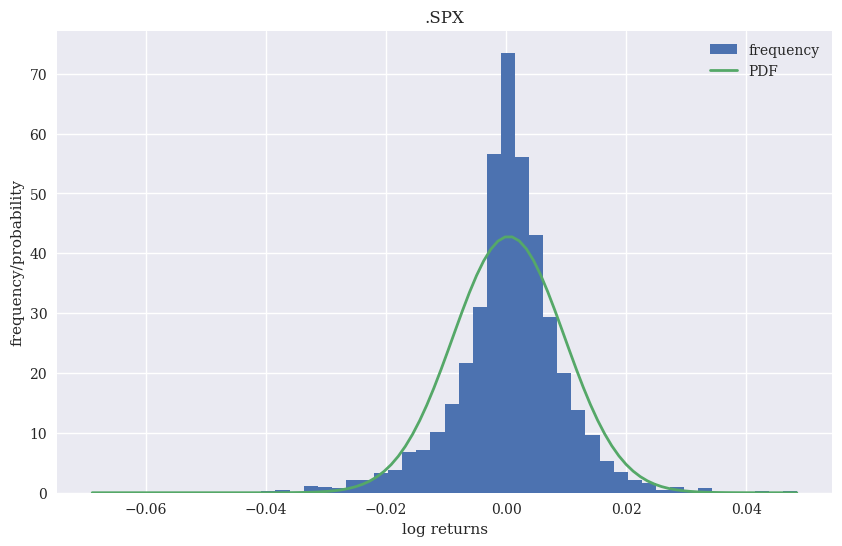

In [26]:
return_histogram(rets[symbol].values, symbol)

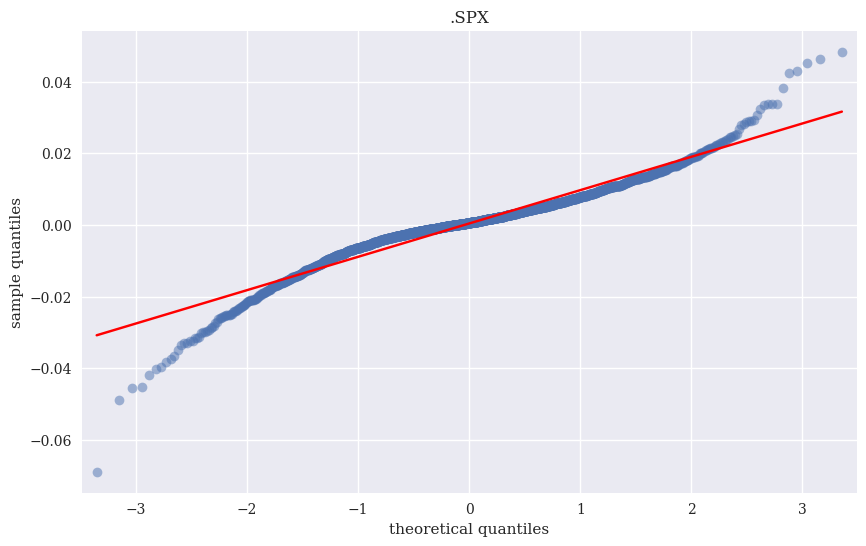

In [27]:
return_qqplot(rets[symbol].values, symbol)

In [28]:
symbols = ['.SPX', 'AMZN.O', 'EUR=', 'GLD']

In [29]:
for sym in symbols:
    print('\n{}'.format(sym))
    print(45 * '=')
    print_statistics(rets[sym].values)


.SPX
RETURN SAMPLE STATISTICS
---------------------------------------------
Skew of Sample Log Returns -0.497160
Skew Normal Test p-value    0.000000
---------------------------------------------
Kurt of Sample Log Returns  4.598167
Kurt Normal Test p-value    0.000000
---------------------------------------------
Normal Test p-value         0.000000
---------------------------------------------

AMZN.O
RETURN SAMPLE STATISTICS
---------------------------------------------
Skew of Sample Log Returns  0.135268
Skew Normal Test p-value    0.005689
---------------------------------------------
Kurt of Sample Log Returns  7.344837
Kurt Normal Test p-value    0.000000
---------------------------------------------
Normal Test p-value         0.000000
---------------------------------------------

EUR=
RETURN SAMPLE STATISTICS
---------------------------------------------
Skew of Sample Log Returns -0.053959
Skew Normal Test p-value    0.268203
---------------------------------------------
K

## Linear Relationships

In [30]:
r = 0.005

In [31]:
market = '.SPX'

In [32]:
res = pd.DataFrame()

In [33]:
for sym in rets.columns[:4]:
    for year in range(2010, 2019):
        rets_ = rets.loc[f'{year}-01-01':f'{year}-12-31']
        muM = rets_[market].mean() * 252
        cov = rets_.cov().loc[sym, market]
        var = rets_[market].var()
        beta = cov / var
        rets_ = rets.loc[f'{year + 1}-01-01':f'{year + 1}-12-31']
        muM = rets_[market].mean() * 252
        mu_capm = r + beta * (muM - r)
        mu_real = rets_[sym].mean() * 252
        res = pd.concat((res, pd.DataFrame({'symbol': sym,
                                       'beta': beta,
                                       'mu_capm': mu_capm,
                                       'mu_real': mu_real},
                                      index=[year + 1])),
                        sort=True)

In [34]:
from sklearn.metrics import r2_score

In [35]:
reg = np.polyfit(res['beta'], res['mu_capm'], deg=1)
res['mu_capm_ols'] = np.polyval(reg, res['beta'])

In [36]:
r2_score(res['mu_capm'], res['mu_capm_ols'])

0.09272355783573527

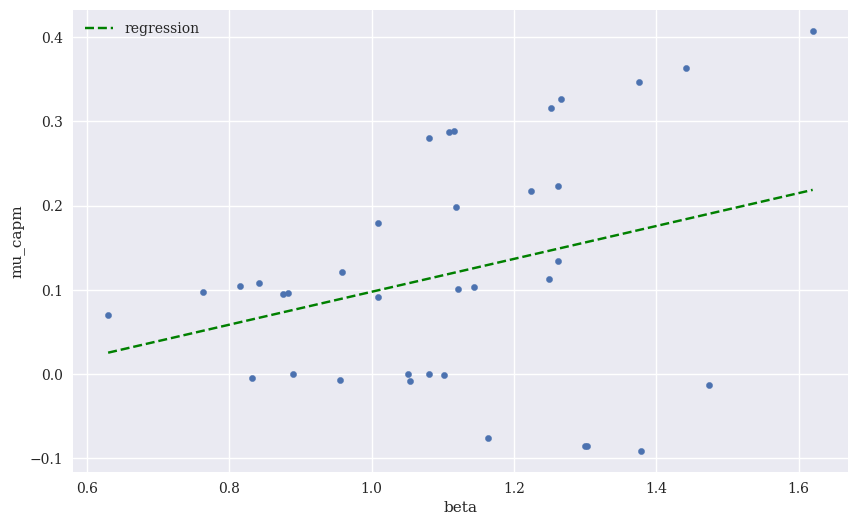

In [37]:
res.plot(kind='scatter', x='beta', y='mu_capm', figsize=(10, 6))
x = np.linspace(res['beta'].min(), res['beta'].max())
plt.plot(x, np.polyval(reg, x), 'g--', label='regression')
plt.legend();

In [38]:
reg = np.polyfit(res['beta'], res['mu_real'], deg=1)
res['mu_real_ols'] = np.polyval(reg, res['beta'])

In [39]:
r2_score(res['mu_real'], res['mu_real_ols'])

0.04466919444752937

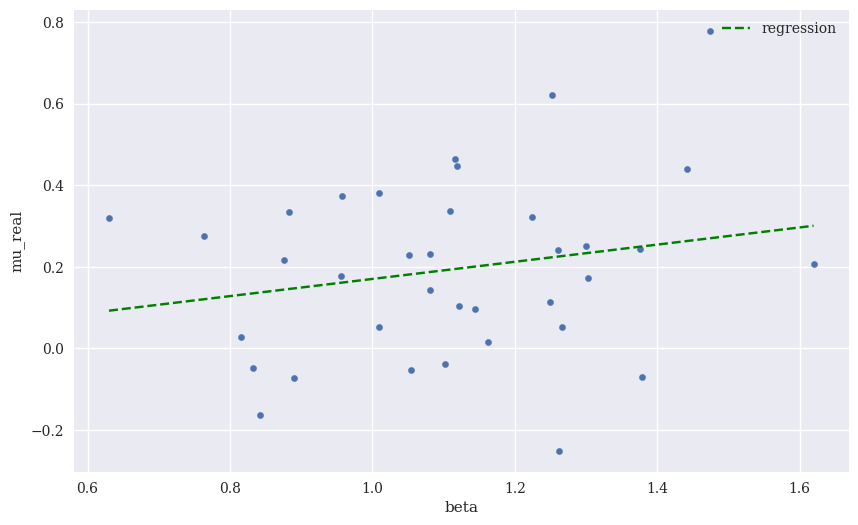

In [40]:
res.plot(kind='scatter', x='beta', y='mu_real', figsize=(10, 6))
x = np.linspace(res['beta'].min(), res['beta'].max())
plt.plot(x, np.polyval(reg, x), 'g--', label='regression')
plt.legend();

<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

<br><br><br><a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:ai@tpq.io">ai@tpq.io</a>